<a href="https://colab.research.google.com/github/linfrick/dip_learners/blob/main/homework_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/dip_learners_folder2

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1TAc4mTQBgA9Db7CkATIg6BYoQuhlOTPb/dip_learners_folder2


In [2]:
### IMPORTARE LIBRERIE GIUSTE E GUARDARE ELENCO SU CODALAB


seed = 2

# Reduce randomness as much as possible
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import random
random.seed(seed)

import numpy as np
np.random.seed(seed)

import tensorflow as tf
tf.random.set_seed(seed)


# Import other libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

from sklearn.model_selection import train_test_split
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3, ResNet50
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Load the data

In [3]:
categories = np.load('categories.npy', allow_pickle=True)
training_data = np.load('training_data.npy', allow_pickle=True)
valid_periods = np.load('valid_periods.npy', allow_pickle=True)

print(categories.shape)
print(training_data.shape)
print(valid_periods.shape)

(48000,)
(48000, 2776)
(48000, 2)


# Inspect the data

In [ ]:
# 6 different categories

# The division into categories may help you to choose the best strategy for
# implementing your model (or possibly your group of models).
# Also remember that time series can have very different lengths

# IMPORTANT: This is a dataset consisting of monovariate time series, i.e.
# composed of a single feature, belonging to six different domains. The time
# series of each domain are not to be understood as closely related to each
# other, but only as collected from similar data sources.
# What is required of you is therefore to build a model that is capable of
# generalising sufficiently to predict the future samples of the 60 time series
# of the test set.

np.unique(categories)

array(['A', 'B', 'C', 'D', 'E', 'F'], dtype='<U1')

In [ ]:
# Each row of the dataset corresponds to a feature and time independent time series.
# Each row of the dataset has been normalised to the range [0,1] independently of the other rows.
# (PS: remember to de-normalise in the prediction function)

print(training_data)

[[0.         0.         0.         ... 0.60277778 0.36759259 0.33148148]
 [0.         0.         0.         ... 0.6        0.46       0.396     ]
 [0.         0.         0.         ... 0.96048126 0.94650625 0.97714021]
 ...
 [0.         0.         0.         ... 0.52631579 0.58223684 0.55263158]
 [0.         0.         0.         ... 0.44559585 0.58549223 0.40414508]
 [0.         0.         0.         ... 0.54268293 0.6097561  0.59146341]]


In [ ]:
# Remember that time series can have very different lengths.

print(valid_periods)

[[2325 2776]
 [2325 2776]
 [2325 2776]
 ...
 [2676 2776]
 [2676 2776]
 [2676 2776]]


In [ ]:
# Do all valid periods end with 2776? Yes.
print(valid_periods[valid_periods[:,1]==2776,:].shape)

print(valid_periods[valid_periods[:,1]==2776,:])

(48000, 2)
[[2325 2776]
 [2325 2776]
 [2325 2776]
 ...
 [2676 2776]
 [2676 2776]
 [2676 2776]]


In [ ]:
# Do all valid periods start before 2500? No.
print(valid_periods[valid_periods[:,0]<2500,:].shape)

print(valid_periods[valid_periods[:,0]>=2500,:])

(14878, 2)
[[2712 2776]
 [2682 2776]
 [2682 2776]
 ...
 [2676 2776]
 [2676 2776]
 [2676 2776]]


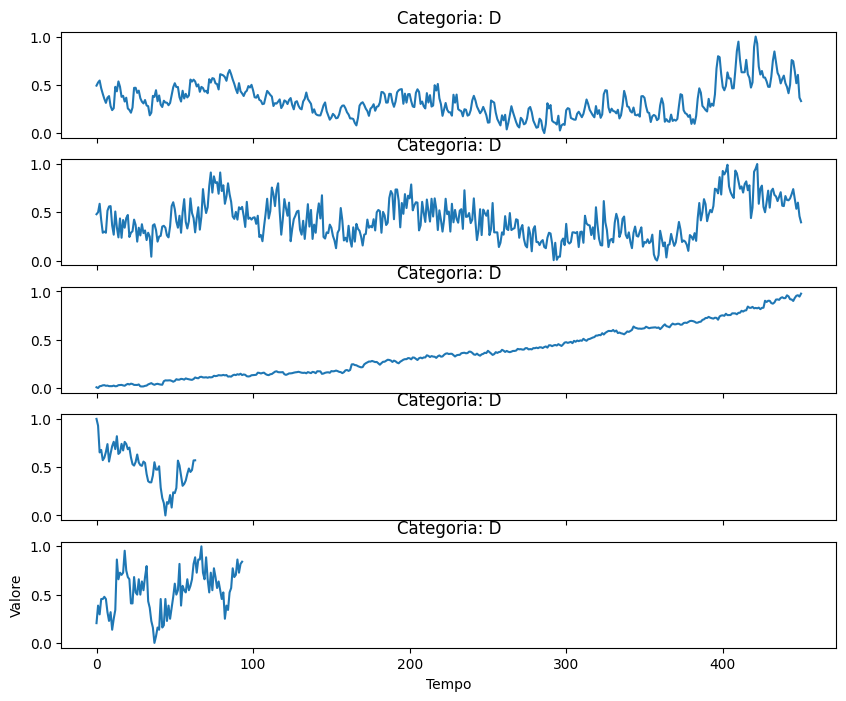

In [ ]:
# Visualizza alcune serie temporali
num_time_series_to_plot = 5
fig, axs = plt.subplots(num_time_series_to_plot, figsize=(10, 8), sharex=True, sharey=True)

for i in range(num_time_series_to_plot):
    start, end = valid_periods[i]
    axs[i].plot(training_data[i, start:end])
    axs[i].set_title(f"Categoria: {categories[i]}")

plt.xlabel("Tempo")
plt.ylabel("Valore")
plt.show()

# Split train validation data

(48000, 2567) (48000, 209)
[[2325 2776]
 [2325 2776]
 [2325 2776]
 ...
 [2676 2776]
 [2676 2776]
 [2676 2776]]


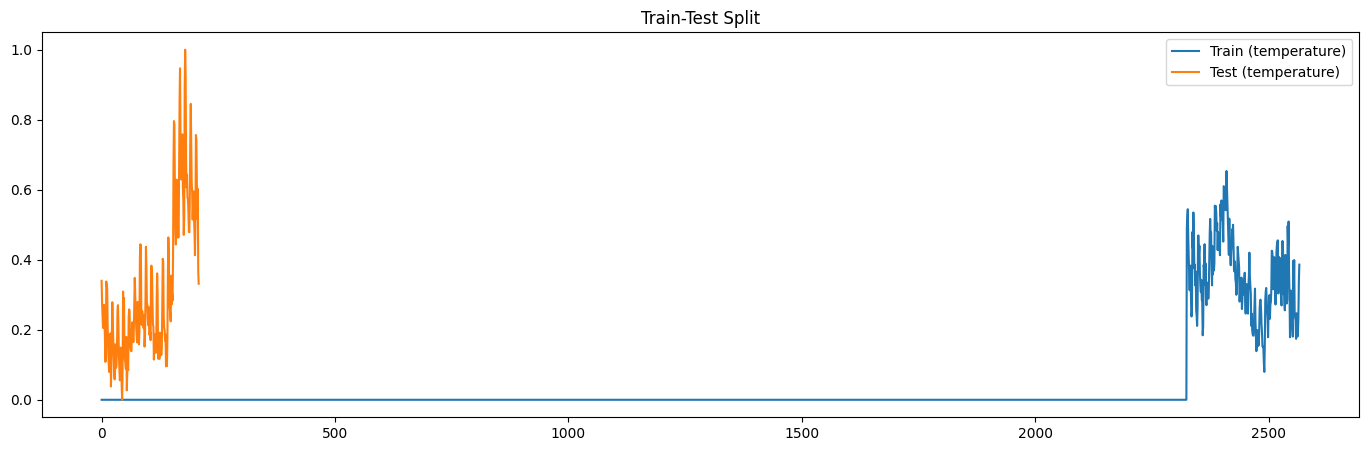

In [32]:
test_size = 209
X_train_raw = training_data[:, :-test_size]
X_test_raw = training_data[:, -test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Compute valid periods of train and test
print(valid_periods)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw[0], label='Train (temperature)')
plt.plot(X_test_raw[0], label='Test (temperature)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [33]:
def build_sequences(data, window=200, stride=2, telescope=18):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    future = []

    # For each row, keep only the valid period, pad it and then make sequences
    for idx, row in enumerate(data):
      start_index = valid_periods[idx,0]

      if(start_index<=2500-window-telescope): #if row has no valid period, ignore

        temp_row = row[start_index:] #keep only valid data of row to create sequences
        padding_check = len(temp_row)%window

        if(padding_check != 0):
            # Compute padding length
            padding_len = window - len(temp_row)%window
            padding = np.zeros(padding_len, dtype='float32')
            temp_row = np.concatenate((padding,temp_row))
            assert len(temp_row) % window == 0


        for i in np.arange(0, len(temp_row) - window - telescope, stride):
            dataset.append(temp_row[i:i + window]) #qui c'era .tolist() prima, in caso serva
            future.append(temp_row[i+window:i+window+telescope])

    dataset = np.array(dataset)
    future = np.array(future)

    return dataset, future

In [34]:
X_train, y_train = build_sequences(X_train_raw)
X_test, y_test = build_sequences(X_test_raw)

In [35]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(206996, 200) (206996, 9) (96, 200) (96, 9)


In [36]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]

print(input_shape, output_shape)

(200,) (9,)


In [41]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(input_layer)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    reshape = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    output_layer = tfkl.Reshape((18,))(reshape)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 conv (Conv1D)               (None, 200, 128)          512       
                                                                 
 output_layer (Conv1D)       (None, 200, 1)            385       
                                                                 
 cropping (Cropping1D)       (None, 9, 1)              0         
                                                                 
 reshape (Reshape)           (None, 9)                 0         
                                                                 
Total params: 897 (3.50 KB)
Trainable params: 897 (3.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


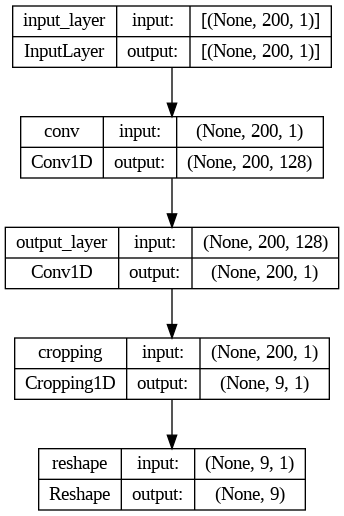

In [42]:
model = build_CONV_LSTM_model((200,1), (9,1)) # serve 1 dopo virgola nelle shape, perché output della rete è (50,1) e per calcolare MSE serve che vettore "vero" abbia stessa shape
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [43]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 64,
    epochs = 20,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/20
2911/2911 [==============================] - 14s 4ms/step - loss: 0.0389 - val_loss: 0.0633 - lr: 0.0010
Epoch 2/20
2911/2911 [==============================] - 17s 6ms/step - loss: 0.0379 - val_loss: 0.0613 - lr: 0.0010
Epoch 3/20
2911/2911 [==============================] - 12s 4ms/step - loss: 0.0376 - val_loss: 0.0616 - lr: 0.0010
Epoch 4/20
2911/2911 [==============================] - 12s 4ms/step - loss: 0.0374 - val_loss: 0.0607 - lr: 0.0010
Epoch 5/20
2911/2911 [==============================] - 13s 5ms/step - loss: 0.0374 - val_loss: 0.0660 - lr: 0.0010
Epoch 6/20
2911/2911 [==============================] - 13s 4ms/step - loss: 0.0373 - val_loss: 0.0607 - lr: 0.0010
Epoch 7/20
2911/2911 [==============================] - 13s 4ms/step - loss: 0.0372 - val_loss: 0.0619 - lr: 0.0010
Epoch 8/20
2911/2911 [==============================] - 12s 4ms/step - loss: 0.0372 - val_loss: 0.0629 - lr: 0.0010
Epoch 9/20
2911/2911 [==============================] - 13s 4ms/step - l

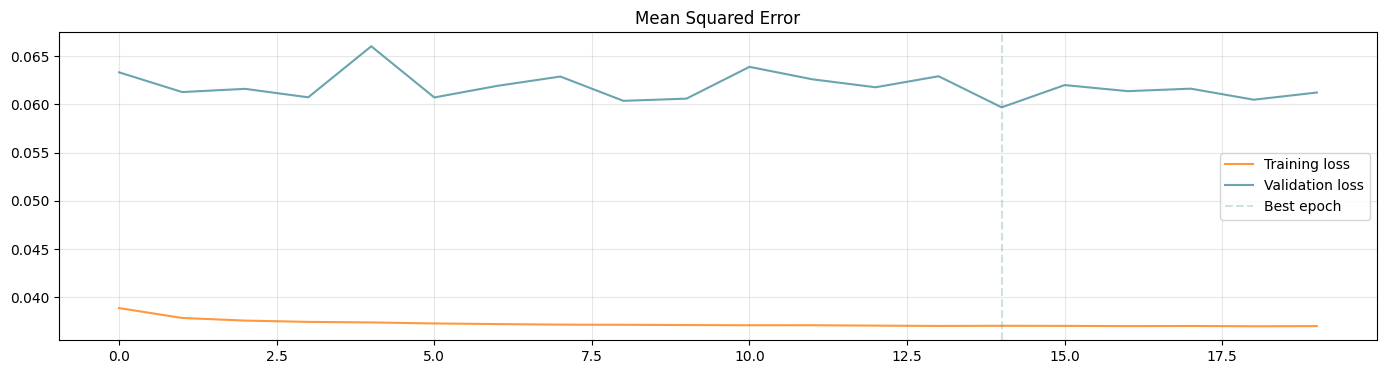

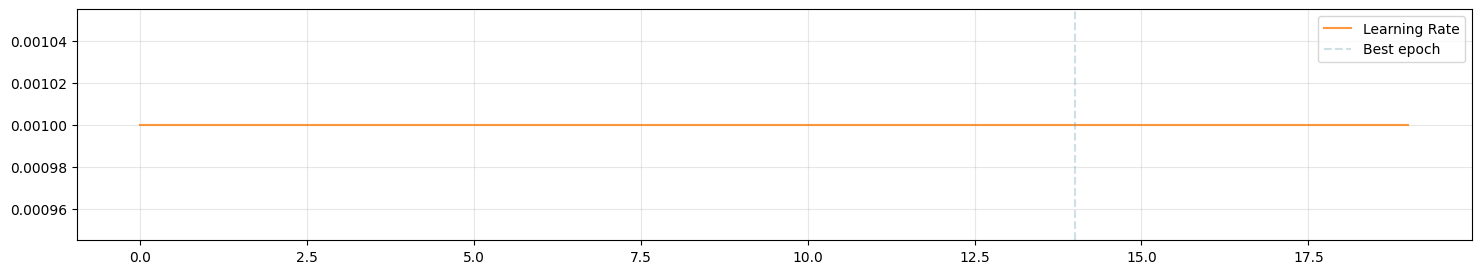

In [44]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [45]:
model.save('reshaped_model')

In [46]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (96, 9)
Mean Squared Error: 0.03504076972603798
Mean Absolute Error: 0.1595020294189453
